In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



In [3]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._backward = lambda: None # By default it is an empty function
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # doing += as gradient needs to be accumulated (multivariate chain rule)
            # if we do =, then it will be overwritten, example in b = a + a + a, b.grad will be 1.0, 
            # but it should be 3.0, This is because all a's are same object

        out._backward = _backward
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            # That's what we have been doing manually till now
        
        out._backward = _backward

        return out
    
    # Define the tanh function
    def tanh(self):
        x = self.data
        # tanh is (e^2x - 1)/(e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        # we are storing the function not callling it, as that will return NONE

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [4]:
# Let's build a simple single neuron

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(n)

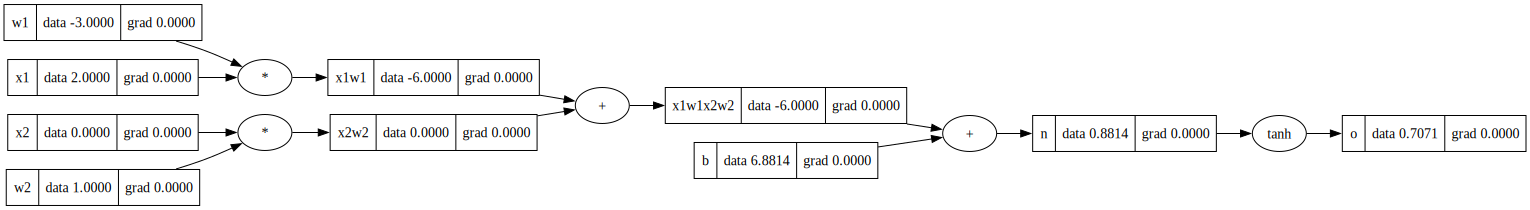

In [5]:
draw_dot(o)

In [6]:
o.backward()

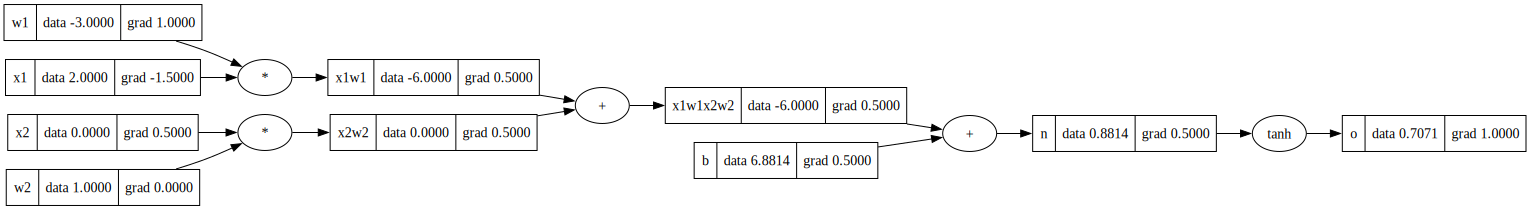

In [7]:
draw_dot(o)

Now we can breakdown tanh even more:

The hyperbolic tangent function is given by:

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$


Also, we can't do something like

In [8]:
# a = Value(2.0)
# a + 1

# AttributeError: 'int' object has no attribute 'data'

This is because 1 is not a value

In [9]:
# we can do something like this

def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

#  similarly we can do this for __mul__
    

In [10]:
# Also we can do (a * 2) but not (2 * a)

# This is because python is doing a.__mul__(2) for (a * 2)

# and 2.__mul__(a) for (2 * a)

In [11]:
# we can add def __rmul__(self, other) to handle this
    #  return self * other
# Basically does other * self when fails to do self * other

Now in order to break tanh even more, we will need to implement how to exponentiate, how to divide and also how to subtract(which is basically adding the negative)

For division we can implement something even better

Basically

$$
\frac{a}{b} = a \cdot \frac{1}{b} = a \cdot b^{-1}
$$


That is we will implement power function

So let's implement everything we mentioned above

In [12]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._backward = lambda: None # By default it is an empty function
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # doing += as gradient needs to be accumulated (multivariate chain rule)
            # if we do =, then it will be overwritten, example in b = a + a + a, b.grad will be 1.0, 
            # but it should be 3.0, This is because all a's are same object

        out._backward = _backward
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            # That's what we have been doing manually till now
        
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float power for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): #other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other ** -1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    # Define the tanh function
    def tanh(self):
        x = self.data
        # tanh is (e^2x - 1)/(e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        # we are storing the function not callling it, as that will return NONE

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [13]:
# a = Value(2.0)
# b = 3.0
# a / b

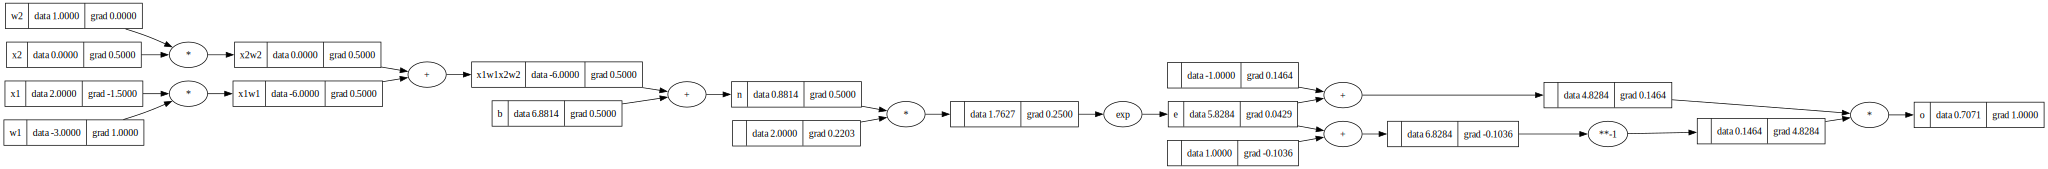

In [14]:
# Let's build a simple single neuron

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# ----------------------------

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()
draw_dot(o)

So both forward and backward pass is working correctly!! 

Also the level at which we implement out operation is totally up to us, we can implement backward passes for tiny expressions like a single individual "+" or we can implement it for tanh

#### Now let's do the exact same thing using modern deep learning neural network library like PyTorch

So let's do the exact same thing but in PyTorch API

Micrograd is a scalar valued engine but we know in PyTorch, every thing is based around tensors which are basically a n-dimensional array of scalars

In [15]:
import torch

In [16]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

# By default pytorch assumes leaf nodes donb't require grad, so we need to set requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# Just like micrograd, it has data and grad attribute

# Since this returns a tensor, that's why we need to do item() to get the value
print(o.data.item())
o.backward()

print("-------------------")

print("x1 grad", x1.grad.item())
print("w1 grad", w1.grad.item())
print("x2 grad", x2.grad.item())
print("w2 grad", w2.grad.item())

0.7071066904050358
-------------------
x1 grad -1.5000003851533106
w1 grad 1.0000002567688737
x2 grad 0.5000001283844369
w2 grad 0.0


Big deal with Pytorch is everything is significantly more efficient because we are working with this tensor objects and we can do a lot of operations in parallel

#### Now let's start Building our Neural Net piece by piece, ultimately will build a two layer MLP

In [17]:
class Neuron:

    def __init__(self, nin):
        # constructor takes nin which is the number of inputs
        self.w = [Value(random.uniform(-1, 1) for _ in range(nin))]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        return 0.0

# This is how __call__ works
x = [2.0, 3.0]
n = Neuron(2)
n(x)


0.0

In [18]:
class Neuron:

    def __init__(self, nin):
        # constructor takes nin which is the number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b

        act = sum((wi* xi for wi, xi in zip(self.w, x)), self.b)
        # startting with b by default, we will add all the weights and inputs

        out = act.tanh()
        return out

x = [2.0, 3.0]
n = Neuron(2)
n(x)


Value(data=0.9720916175016708)

So we just implemented forward pass for a single neuron. Let's do it for a layer of neurons

In [19]:
class Neuron:

    def __init__(self, nin):
        # constructor takes nin which is the number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b

        act = sum((wi* xi for wi, xi in zip(self.w, x)), self.b)
        # startting with b by default, we will add all the weights and inputs

        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
# So now instead of a Neuron, we can have a Layer of Neurons
x = [2.0, 3.0]

# Let's make a 2 dimensional layer with 3 neurons
n = Layer(2,3)

n(x)

[Value(data=-0.9396436673692335),
 Value(data=0.6377321533845829),
 Value(data=-0.8456928995896074)]

Greatt! Now let's define multi layer, a proper MLP

In [20]:
class Neuron:

    def __init__(self, nin):
        # constructor takes nin which is the number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b

        act = sum((wi* xi for wi, xi in zip(self.w, x)), self.b)
        # startting with b by default, we will add all the weights and inputs

        out = act.tanh()
        return out
    
    # def parameters(self):
    #     # return all the parameters of the neuron
    #     return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # return outs
        return outs[0] if len(outs) == 1 else outs
    
    # def parameters(self):
    #     # params = []
    #     # for neuron in self.neurons:
    #     #     ps = neuron.parameters()
    #     #     params.extend(ps)
    #     # return params

    #     return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        # constructor takes nin which is the number of inputs as before but now
        # instead of a single nout, we are going to take a list of nouts
        # and this list defines sizes of all layer that we want in out MLP

        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    # def parameters(self):
    #     return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]

n = MLP(3, [4, 4, 1])
# Takes 3 inputs, 3 layers, 4 neurons in 2 layer, 1 output

n(x)

Value(data=0.768917270690833)

You see how this is returning a list, So in the Layer's __output__, you can do something like \
return outs[0] if len(outs) == 1 else outs

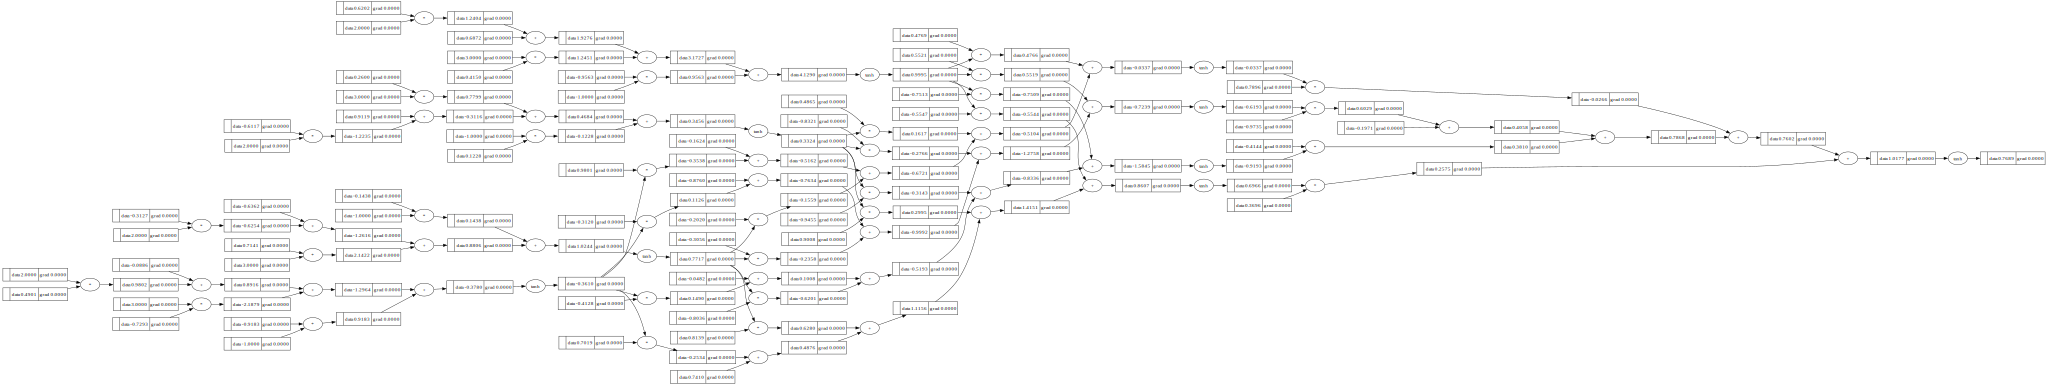

In [21]:
draw_dot(n(x))

#### Let's create a sample dataset

In [22]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Let's get predictions from our neural net
ypred = [n(x) for x in xs]

ypred

[Value(data=0.768917270690833),
 Value(data=-0.2684167919663496),
 Value(data=0.48065448747927597),
 Value(data=0.9339560167479479)]

Ofcourse not performing very well, Let's implement a squared error loss, which is just the diffeence between ground truth and actual output squared

In [23]:
# Individual loss for each example
[(yout - ygt)**2 for yout, ygt in zip(ypred, ys)]

[Value(data=0.05339922778497373),
 Value(data=0.5352139902768074),
 Value(data=2.1923377112925175),
 Value(data=0.004361807723797335)]

In [24]:
# loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

# TypeError: unsupported operand type(s) for +: 'int' and 'Value'

# The error is happening because Python's built-in sum() function starts with an initial value of 0 (an integer) 
# and tries to add Value objects to it. We need to provide an initial value that's a Value object.

loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss

Value(data=2.785312737078096)

In [25]:
loss.backward()

In [26]:
# Now due to the above backward pass, the weights will have grads now
n.layers[0].neurons[0].w[0].grad

0.3758385662903873

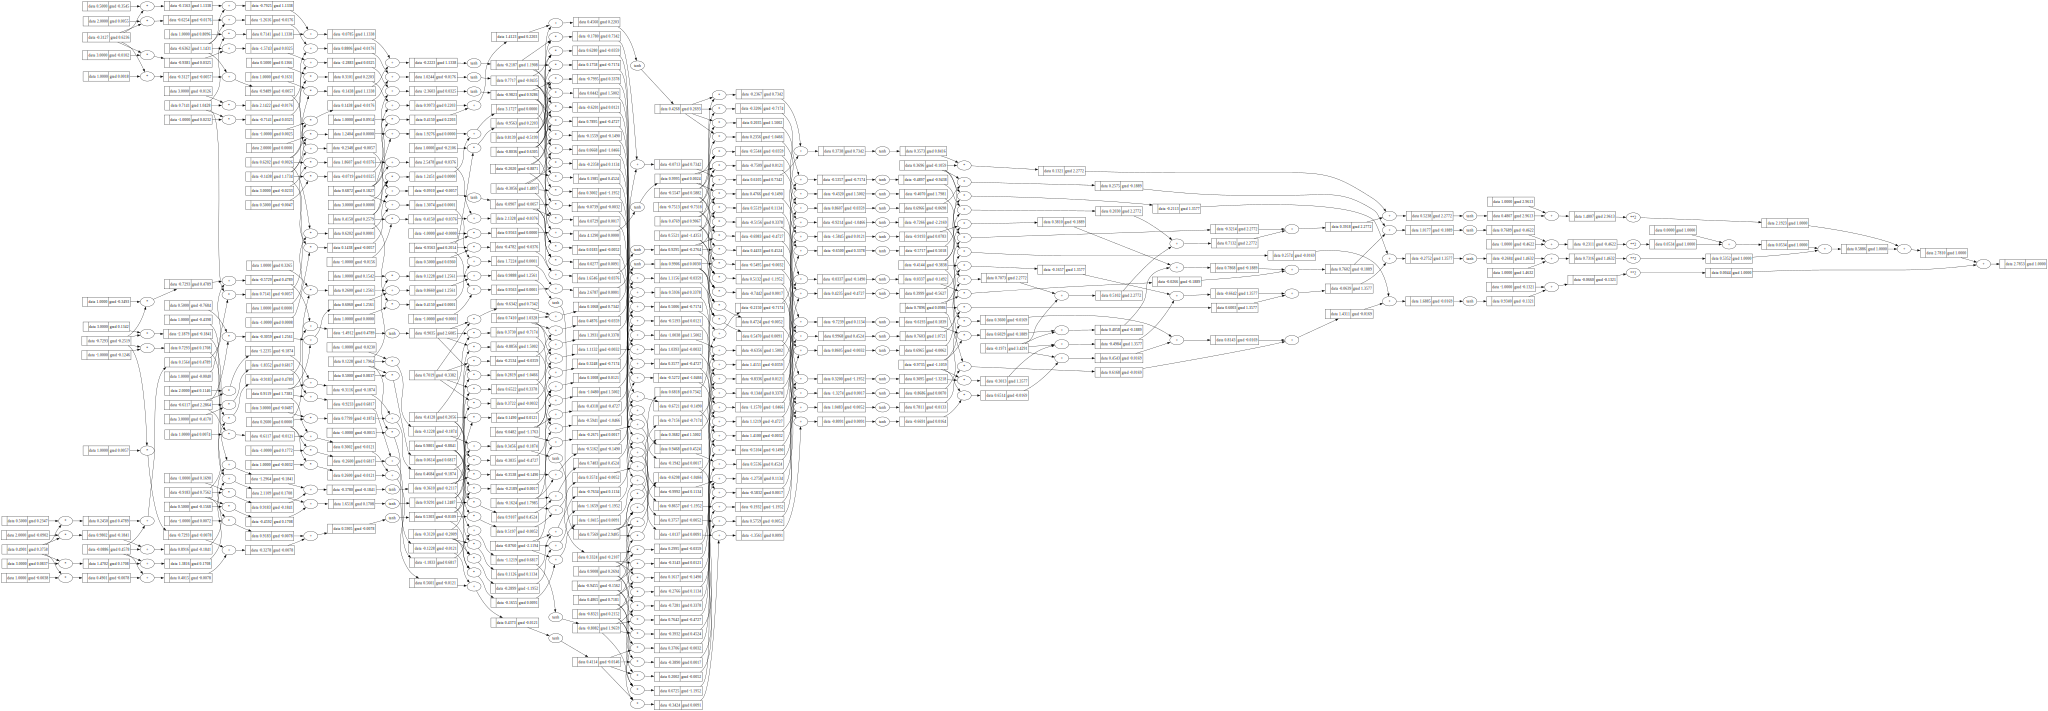

In [27]:
draw_dot(loss)

We can see even data has grads, But we don't want to change data but weights and bias only! So let;s define a function to get all the parameters

In [28]:
class Neuron:

    def __init__(self, nin):
        # constructor takes nin which is the number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b

        act = sum((wi* xi for wi, xi in zip(self.w, x)), self.b)
        # startting with b by default, we will add all the weights and inputs

        out = act.tanh()
        return out
    
    def parameters(self):
        # return all the parameters of the neuron
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # return outs
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        # constructor takes nin which is the number of inputs as before but now
        # instead of a single nout, we are going to take a list of nouts
        # and this list defines sizes of all layer that we want in out MLP

        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [29]:
x = [2.0, 3.0, -1.0]

n = MLP(3, [4, 4, 1])
# Takes 3 inputs, 3 layers, 4 neurons in 2 layer, 1 output

n(x)

Value(data=-0.18906028382232523)

In [30]:
len(n.parameters())

41

In [31]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Let's get predictions from our neural net
ypred = [n(x) for x in xs]

ypred

[Value(data=-0.18906028382232523),
 Value(data=-0.4193942246196677),
 Value(data=0.2933061434954696),
 Value(data=0.19345368852500275)]

In [32]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss

Value(data=4.074125158325673)

In [33]:
loss.backward()

In [34]:
n.layers[0].neurons[0].w[0].grad

2.746618516785528

In [35]:
n.layers[0].neurons[0].w[0].data

0.5141458329781876

In [36]:
# Gradient descent update
for p in n.parameters():
    # 0.001 is the learning rate
    p.data -= 0.01 * p.grad

This is what the Workflow will look like
1. Predict
2. Backward
3. update

In [37]:
# 1. Predict
ypred = [n(x) for x in xs]
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss

Value(data=3.444976713419198)

In [38]:
# loss started with 3.4
# after iterations went to 0.0003 something
# then boom 9.9e-06 so much less than before
# Means our predictions are getting better

In [39]:
# 2. Backward
loss.backward()

In [40]:
# Update
for p in n.parameters():
    p.data -= 0.01 * p.grad

If you run these three steps again and again you can see loss decreasing in rach iteration(and  ofcourse after one point it will start increasing if step size exceeds)

#### Let's be little respectable and write a training loop

In [41]:
for k in range(10):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data -= 0.01 * p.grad

    print(k, loss.data)

0 2.6657096975729266
1 2.0366078200480064
2 1.4105288605091957
3 0.9530633623129957
4 0.8671187573468345
5 0.7302922938242358
6 0.40292401587607696
7 0.14795480194766258
8 0.0438945166215325
9 0.012244878168701727


#### Okkayyy we have a Bug

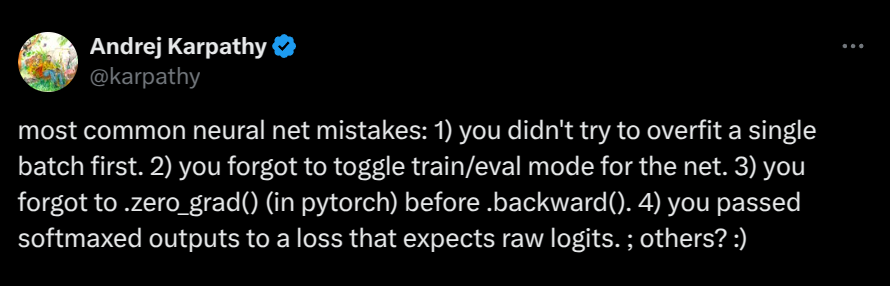

We fell victim of number 3, basically remember how we are doing += in grads, so actually when we are updating the data and not flusing the grad, it stays there, so when we do the second forward pass and do the backward again, the backward operations does a += on the grad, so thes gradients just add up and they never get reset to 0

In [42]:
for k in range(10):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
        # grad is reset to 0 just like in constructor
    loss.backward()

    # update
    for p in n.parameters():
        p.data -= 0.01 * p.grad

    print(k, loss.data)

0 0.0034262582477475245
1 0.0034153628918175806
2 0.003404539299112631
3 0.0033937867574732146
4 0.0033831045641700497
5 0.0033724920257481353
6 0.0033619484578738066
7 0.0033514731851849514
8 0.0033410655411440604
9 0.0033307248678942263


Now you won't get such low loss when you initiate everything. Here the dataset was so simple that it was easier to overfit